<a href="https://colab.research.google.com/github/PKghose/PKghose.github.io/blob/main/Brain_Tumor_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [8]:
import kagglehub
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define your Google Drive path
drive_path = "/content/drive/MyDrive/colabnotebook/brainseg"

# Create the directory if it doesn't exist
os.makedirs(drive_path, exist_ok=True)

# Download the dataset using kagglehub
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import callbacks
import seaborn as sns
from skimage.io import imread, imsave
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as K
import tensorflow_hub as hub
import matplotlib.image as img

Define folder

In [10]:
train_dir = "/content/drive/MyDrive/Colab Notebook/Brainseg/Testing"

test_dir = "/content/drive/MyDrive/Colab Notebook/Brainseg/Training"

img_size = (224 , 224)

batch_size = 32

Getting data

In [11]:
#Define train_data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "int" ,
    batch_size = batch_size ,
    )

#Define Classes Names
class_names= train_data.class_names
class_names


Found 1311 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

visualizing some Random Samples

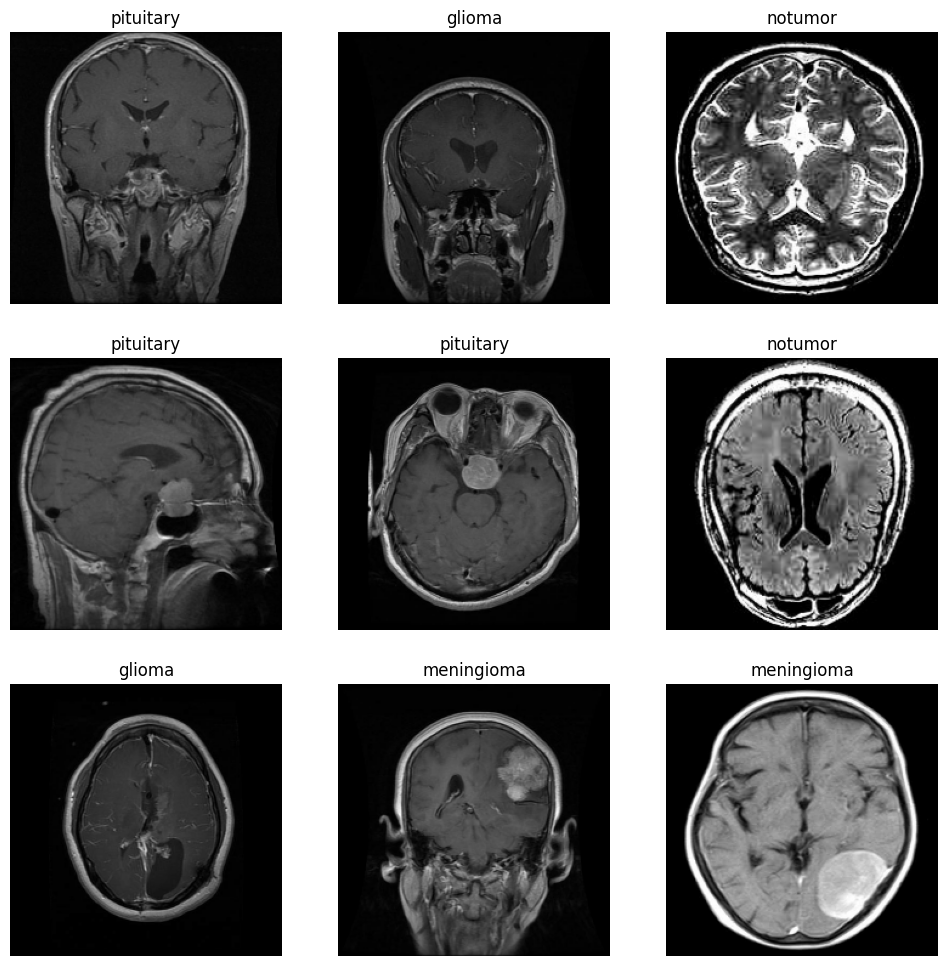

In [12]:
plt.figure(figsize=(12, 12))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Imbalanced data Check


In [13]:
#Deifne a Function to get number of each class samples
def each_class_samples(train_data):
    """
    taking the train data and returns the number of each class samples

    """
    #Set up counters
    meningioma = 0
    notumor = 0
    glioma = 0
    pituitary = 0

    #Looping over the train_data
    for images, labels in train_data:
        for i in range(len(images)):
            if class_names[labels[i]] == 'meningioma':
                meningioma +=1
            elif class_names[labels[i]] == 'notumor':
                notumor +=1
            elif class_names[labels[i]] == 'glioma':
                glioma +=1
            elif class_names[labels[i]] == 'pituitary':
                pituitary +=1
    print("meningioma : " + str(meningioma))
    print("glioma : " + str(glioma))
    print("notumor : " + str(notumor))
    print("pituitary : " + str(pituitary))
    return [meningioma , glioma , notumor , pituitary]




#Trying our function
meningioma  , glioma , notumor , pituitary = each_class_samples(train_data)

meningioma : 306
glioma : 300
notumor : 405
pituitary : 300


In [14]:
# Plotting numbers of each class
fig = go.Figure(go.Bar(
            x= [meningioma,glioma,pituitary,notumor],
            y= ['meningioma','glioma','pituitary','notumor'],
            orientation='h' ,) )

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)


fig.show()

Modelling_1 (Using EfficientNetB7)

Defining Datakoader and callBack_List


In [15]:
#Defining some constants
img_size = (224 , 224)
batch_size = 32


#Defining train_data again
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining Test_data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir ,
    image_size = img_size ,
    label_mode = "categorical" ,
    batch_size = batch_size ,)


#Defining CallBack list

callback_list=[
    callbacks.EarlyStopping(monitor="val_accuracy",patience=10,restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.8,monitor="val_accuracy",patience=3)
]

Found 1311 files belonging to 4 classes.
Found 5712 files belonging to 4 classes.


In [16]:
# prompt: how to chech test data size

print(len(test_data))


179


## Modelling
* First Stage : BaseModel(Freezed) . add[Conv2D layer(`will help us in the segmentation part`)] . add[Global avg pooling layer] . add[Dense Layer] and train for 5 epochs
* Second Stage: BaseModel(un freeze last 10 layers) . ReCompile[and reduce learning rate by 10x]
* Last : [Apply Grad Cam Segmentation]

1.First Stage: Building the model



In [17]:

#--Define Base_Model (EfficientNetB0)

base_model = tf.keras.applications.EfficientNetB7(include_top = False) #excluding the top layer

base_model.trainable = False #--> Freezing the model parameters (Make it's parameter not learnable)

inputs = tf.keras.layers.Input(shape = (224 , 224 , 3) , name = "Input_layer") #--> Define the input layer

x = base_model(inputs)

x = Conv2D(32 , 3 , padding = 'same' , activation = "relu" , name = "Top_Conv_Layer")(x) #--> add a Conv2D layer which we will use in the segmentation as the Top conv Layer

x = tf.keras.layers.GlobalAveragePooling2D(name = "Global_avg_Pooling_2D")(x) #--> Add Global Average Pooling Layer 2D

outputs = tf.keras.layers.Dense(4 , #--> Because we have 4 Classes
                                activation = "softmax" , #we will change it to linear when we apply sigmentation
                                name = "Output_layer")(x)
Model_1 = tf.keras.Model(inputs , outputs) #--> Defining the model


#Compile the model

Model_1.compile(
    loss = tf.keras.losses.categorical_crossentropy ,#--> Multiclass classification
    optimizer = tf.keras.optimizers.SGD() , #--> Adam optimizer with Learning_rate = 0.001
    metrics = ['accuracy']
)


#Fitting the model for 20 epochs

Model_1_History = Model_1.fit(train_data
                              , validation_data = test_data ,
                              epochs = 10  ,
                              verbose = 1 ,
                              callbacks = callback_list)


258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 219s 4s/step - accuracy: 0.5761 - loss: 1.0400 - val_accuracy: 0.8064 - val_loss: 0.6037 - learning_rate: 0.0100
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8207 - loss: 0.5396 - val_accuracy: 0.8132 - val_loss: 0.5204 - learning_rate: 0.0100
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8469 - loss: 0.4302 - val_accuracy: 0.8664 - val_loss: 0.4132 - learning_rate: 0.0100
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8823 - loss: 0.3564 - val_accuracy: 0.8755 - val_loss: 0.3680 - learning_rate: 0.0100
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8928 - loss: 0.3208 - val_accuracy: 0.8831 - val_loss: 0.3390 - learning_rate: 0.0100
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9085 - loss: 0.2836 - val_accuracy: 0.8829 - val_loss: 0.3405 - learning_rate: 0.0100
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/s

 Plot loss curves

In [18]:
#Define the function to plot loss and accuracy curves of train - valid
def plot_loss_curves(history):
    train_loss = history.history["loss"]
    val_loss = history.history['val_loss']
    train_accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    epochs = range(len(history.history["loss"]))
    #Plot Loss
    plt.plot(epochs , train_loss , label = "Train Loss")
    plt.plot(epochs , val_loss , label = "Val Loss" )
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.legend()
    #Plot accuracy
    plt.figure()
    plt.plot(epochs ,train_accuracy , label = "train_accuracy")
    plt.plot(epochs , val_accuracy , label = "val_accuracy" )
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.legend()

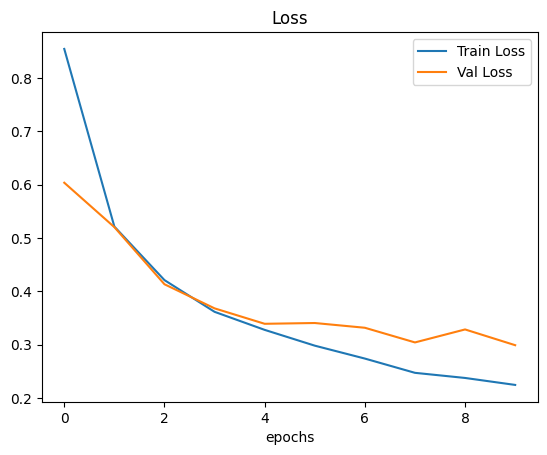

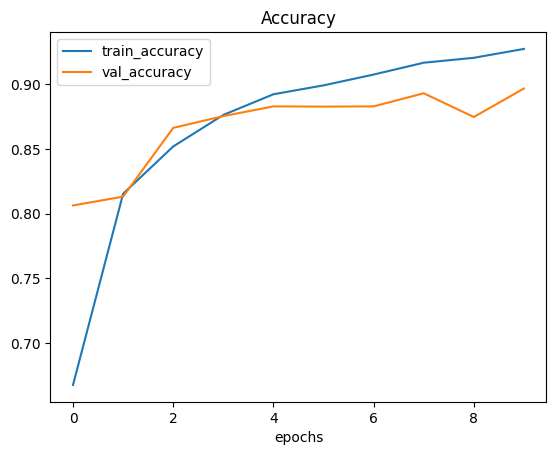

In [19]:
#Use out function
plot_loss_curves(Model_1_History)

 Second Stage Training
* unfreaze Last 10 Layers of the Base model
* Lower the learning rate of Adam optimizer

In [20]:
# Un freaze all the Base_model
base_model.trainable = True

#Freezing all the layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False


#ReCompile the model
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001), #--< When FineTuning u want to lower the LR by 10x
                metrics = ["accuracy"]
               )


#FineTune for 10 epochs
initial_epoch = 20

Fine_Tune_epoch = initial_epoch + 5

#Refit the model
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 20/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.8966 - loss: 0.3056 - val_accuracy: 0.8438 - val_loss: 0.4138
Epoch 21/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9498 - loss: 0.1884 - val_accuracy: 0.8913 - val_loss: 0.2978
Epoch 22/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9573 - loss: 0.1368 - val_accuracy: 0.9109 - val_loss: 0.2432
Epoch 23/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9711 - loss: 0.0811 - val_accuracy: 0.9182 - val_loss: 0.2308
Epoch 24/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9806 - loss: 0.0766 - val_accuracy: 0.9193 - val_loss: 0.2310
Epoch 25/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9892 - loss: 0.0461 - val_accuracy: 0.9207 - val_loss: 0.2232


In [21]:
#ReCompile the model and reduce Learning rate by 10x
Model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(learning_rate= 0.00001), #--< lower the LR by 10x
                metrics = ["accuracy"]
               )
initial_epoch = 10
Fine_Tune_epoch = initial_epoch + 1
#Refit the model for 2 more epochs
Stage_2_history = Model_1.fit(train_data ,
                              epochs = Fine_Tune_epoch ,
                              validation_data = test_data ,
                              validation_steps = len(test_data) ,
                              initial_epoch = initial_epoch-1)

Epoch 10/11
41/41 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.9932 - loss: 0.0389 - val_accuracy: 0.9226 - val_loss: 0.2165
Epoch 11/11
41/41 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.9974 - loss: 0.0255 - val_accuracy: 0.9228 - val_loss: 0.2165


In [49]:
# Model_1.save("brain_detection_model.h5")
# Save the model to the desired path
model_save_path = '/content/drive/MyDrive/Colab Notebook/Brainseg/model.h5'
Model_1.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: /content/drive/MyDrive/Colab Notebook/Brainseg/model.h5


In [22]:
# from sklearn.metrics import classification_report

# # Evaluate the model on the test data
# test_loss, test_accuracy = Model_1.evaluate(test_data)

# # Get the predictions on the test data
# y_pred = Model_1.predict(test_data)
# y_pred_classes = np.argmax(y_pred, axis=1)

# # Extract the true labels from the test data
# y_true_classes = []
# for images, labels in test_data:
#     y_true_classes.extend(np.argmax(labels, axis=1))

# # Generate the classification report
# class_report = classification_report(y_true_classes, y_pred_classes)

# # Print the classification report
# print(class_report)


179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 237ms/step - accuracy: 0.9237 - loss: 0.2056
179/179 ━━━━━━━━━━━━━━━━━━━━ 78s 337ms/step
              precision    recall  f1-score   support

           0       0.24      0.25      0.25      1321
           1       0.24      0.23      0.24      1339
           2       0.29      0.27      0.28      1595
           3       0.25      0.27      0.26      1457

    accuracy                           0.26      5712
   macro avg       0.26      0.26      0.26      5712
weighted avg       0.26      0.26      0.26      5712



 Segmentation part Using Grad-cam


 Define some Functions

In [23]:
#Define Some Functions :

last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size = (224 , 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model = Model_1 , last_conv_layer_name = last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4 , view = False):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    if view :
        display(Image(cam_path))



def decode_predictions(preds):
    classes = ['Glioma' , 'meningioma' , 'No Tumor' , 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction



def make_prediction (img_path , model = Model_1 , last_conv_layer_name = last_conv_layer_name , campath = "cam.jpeg" , view = False):
    img = get_img_array(img_path = img_path)
    img_array = get_img_array(img_path, size=(224 , 224))
    preds = Model_1.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap , cam_path=campath , view = view)
    return [campath , decode_predictions(preds)]

In [50]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image

# Load your saved model
model_path = '/content/drive/MyDrive/Colab Notebook/Brainseg/model.h5'
Model_1 = keras.models.load_model(model_path)

last_conv_layer_name = "Top_Conv_Layer"

def get_img_array(img_path, size=(224, 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model=Model_1, last_conv_layer_name=last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4, view=False):
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps["jet"]
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    if view:
        display(Image(cam_path))

def decode_predictions(preds):
    classes = ['Glioma', 'meningioma', 'No Tumor', 'Pituitary']
    prediction = classes[np.argmax(preds)]
    return prediction

def make_prediction(img_path, model=Model_1, last_conv_layer_name=last_conv_layer_name, campath="cam.jpeg", view=False):
    img_array = get_img_array(img_path, size=(224, 224))
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    save_and_display_gradcam(img_path, heatmap, cam_path=campath, view=view)
    return [campath, decode_predictions(preds)]

# Example usage:
# img_path = "path_to_your_image"
# result = make_prediction(img_path, model=Model_1, last_conv_layer_name="Top_Conv_Layer", campath="grad_cam_result.jpg", view=True)


# Trying the segmentation on 1 MRI image


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning:

The structure of `inputs` doesn't match the expected structure.
Expected: ['Input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))



meningioma


(np.float64(-0.5), np.float64(439.5), np.float64(277.5), np.float64(-0.5))

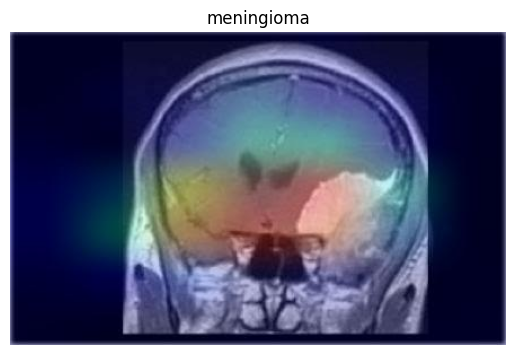

In [51]:
campath , prediction = make_prediction("/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/meningioma/Te-meTr_0000.jpg" , campath="123.jpeg" , view = False)
print(prediction)
test_img = img.imread(campath)
plt.imshow(test_img)
plt.title(prediction)
plt.axis("off")

# Trying the segmentation on 9 MRI images


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


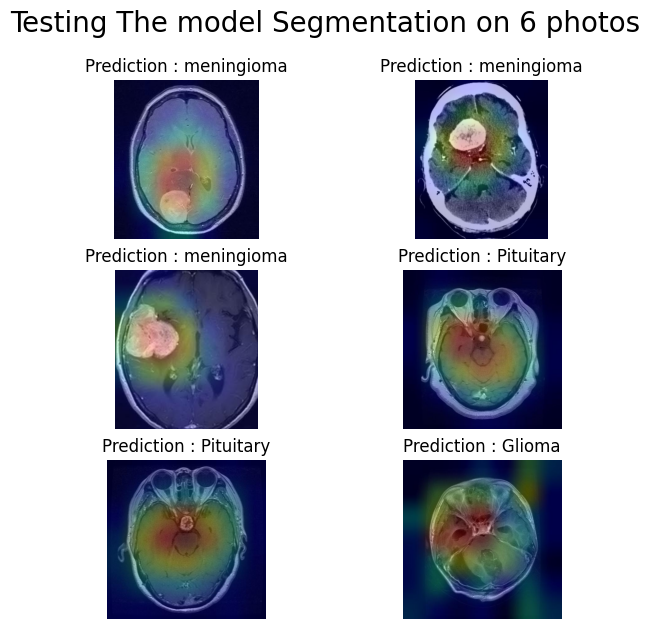

In [26]:
#Define photos paths :
path_array = [
  '/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/meningioma/Te-me_0010.jpg',
  '/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/meningioma/Te-me_0015.jpg' ,
  '/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/meningioma/Te-me_0025.jpg' ,
  '/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/pituitary/Te-pi_0010.jpg' ,
  '/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/pituitary/Te-pi_0021.jpg' ,
  '/content/drive/MyDrive/Colab Notebook/Brainseg/Testing/glioma/Te-glTr_0000.jpg' ,

]


fig = plt.figure(figsize=(7, 7))
fig.suptitle("Testing The model Segmentation on 6 photos" , fontsize = 20)
for images, labels in train_data.take(1):
    for i in range(6):
        ax = plt.subplot(3, 2, i + 1)
        campath , prediction = make_prediction(path_array[i] , campath=f"{i}.jpeg")
        test_img = img.imread(campath)
        plt.imshow(test_img)
        plt.title("Prediction : " + prediction)
        plt.axis("off")